https://www.sbert.net/index.html
1. Separar em tópicos (SBERT - assymetric semantic search / clustering / topic modelling)
2. Encontrar perguntas dentro de tópicos relevantes (manual)
3. Obter sinônimos para aquelas perguntas (SBERT - symmetric semantic search)
4. Extrair pares pergunta-resposta (IBM - domain-specific-QA)

# Assymmetric Semantic Search
For asymmetric semantic search, you usually have a short query (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like “What is Python” and you wand to find the paragraph “Python is an interpreted, high-level and general-purpose programming language. Python’s design philosophy …”. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.   
<br>
### Suitable models for assymmetric semantic search:

- msmarco-distilbert-base-v2

# Symmetric Semantic Search
For symmetric semantic search your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be “How to learn Python online?” and you want to find an entry like “How to learn Python on the web?”. For symmetric tasks, you could potentially flip the query and the entries in your corpus.   
<br>
### Suitable models for symmetric semantic search:

- paraphrase-distilroberta-base-v1 / paraphrase-xlm-r-multilingual-v1

- quora-distilbert-base / quora-distilbert-multilingual

- distiluse-base-multilingual-cased-v2

In [ ]:
"""SBERT - symmetric semantic search
This script contains an example how to perform semantic search with PyTorch. It performs exact nearest neighborh search.
As dataset, we use the Quora Duplicate Questions dataset, which contains about 500k questions (we only use about 100k):
https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs
As embeddings model, we use the SBERT model 'quora-distilbert-multilingual',
that it aligned for 100 languages. I.e., you can type in a question in various languages and it will
return the closest questions in the corpus (questions in the corpus are mainly in English).
Google Colab example: https://colab.research.google.com/drive/12cn5Oo0v3HfQQ8Tv6-ukgxXSmT3zl35A?usp=sharing
"""
from sentence_transformers import SentenceTransformer, util
import os
import csv
import pickle
import time

model_name = 'quora-distilbert-base'
model = SentenceTransformer(model_name)

url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 100000

embedding_cache_path = 'quora-embeddings-{}-size-{}.pkl'.format(
    model_name.replace('/', '_'), max_corpus_size)

#Check if embedding cache path exists
if not os.path.exists(embedding_cache_path):
    # Check if the dataset exists. If not, download and extract
    # Download dataset if needed
    if not os.path.exists(dataset_path):
        print("Download dataset")
        util.http_get(url, dataset_path)

    # Get all unique sentences from the file
    corpus_sentences = set()
    with open(dataset_path, encoding='utf8') as fIn:
        reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            corpus_sentences.add(row['question1'])
            if len(corpus_sentences) >= max_corpus_size:
                break

            corpus_sentences.add(row['question2'])
            if len(corpus_sentences) >= max_corpus_size:
                break

    corpus_sentences = list(corpus_sentences)
    print("Encode the corpus. This might take a while")
    corpus_embeddings = model.encode(corpus_sentences,
                                     show_progress_bar=True,
                                     convert_to_tensor=True)

    print("Store file on disc")
    with open(embedding_cache_path, "wb") as fOut:
        pickle.dump(
            {
                'sentences': corpus_sentences,
                'embeddings': corpus_embeddings
            }, fOut)
else:
    print("Load pre-computed embeddings from disc")
    with open(embedding_cache_path, "rb") as fIn:
        cache_data = pickle.load(fIn)
        corpus_sentences = cache_data['sentences'][0:max_corpus_size]
        corpus_embeddings = cache_data['embeddings'][0:max_corpus_size]

###############################
print("Corpus loaded with {} sentences / embeddings".format(
    len(corpus_sentences)))

#Move embeddings to the target device of the model
corpus_embeddings = corpus_embeddings.to(model._target_device)

while True:
    inp_question = input("Please enter a question: ")

    start_time = time.time()
    question_embedding = model.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    end_time = time.time()
    hits = hits[0]  #Get the hits for the first query

    print("Input question:", inp_question)
    print("Results (after {:.3f} seconds):".format(end_time - start_time))
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'],
                                    corpus_sentences[hit['corpus_id']]))

    print("\n\n========\n")

# Extraindo apenas queries do MSMARCO

In [ ]:
# abre o json
import json
path = r"D:\Gabriel\Documents\TCC\MS MARCO\train_v2.1.json"
with open(path, 'r') as f:
    file = f.read()
    msmarco = json.loads(file)
del file

In [ ]:
# pega as queries e passa para string
msmarco_queries = ';'.join(msmarco['query'].values())
del msmarco

In [24]:
# escreve a string num arquivo
with open("D:\Gabriel\Documents\TCC\MS MARCO\queries.txt", "w", encoding='utf8') as f2:
    f2.write(msmarco_queries)

In [1]:
# lê a string do arquivo
with open("D:\Gabriel\Documents\TCC\MS MARCO\queries.txt", "r", encoding='utf8') as f3:
    msmarco_queries = f3.read()
print(msmarco_queries[0:1000])

)what was the immediate impact of the success of the manhattan project?;_________ justice is designed to repair the harm to victim, the community and the offender caused by the offender criminal act. question 19 options:;why did stalin want control of eastern europe;why do nails get rusty;depona ab;is the atlanta airport the busiest in the world;nyu tuition cost;at what age do kids start to hold memories;average teeth brushing time;is funner a word?;what direction does phloem flow;what is ce certified;artin chicken mcdonalds calories;is panglao island safe;what is calomel powder used for?;sum of squares of even numbers formula;bancfirst customer service number;what is happening in montreal in august?;what county is dewitt michigan in?;how to create msn email address;using cpap without prescription;what is early bird check in southwest;excel if as an array function;what county is columbus city in;social security administration in bellevue wa hours;are whiskers on cats used for balance;w

# Topic modelling with BERT

## Installs

In [ ]:
!pip install umap-learn tqdm

In [ ]:
!pip install hdbscan

In [ ]:
# Demorado! ~3 GB
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
# verificar se está instalado corretamente
import torch
print(torch.cuda.is_available()) # True
print(torch.cuda.current_device()) # int
print(torch.cuda.device_count()) # >0
print(torch.cuda.get_device_name(0)) # GeForce ...

True
0
1
GeForce GTX 1050 Ti


## Imports

In [1]:
from tqdm import tqdm
import umap
import os
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option("display.max_rows", 10, "display.max_columns", None, "display.width", None, "display.max_colwidth", 70)

## Obter data

In [6]:
with open("D:\Gabriel\Documents\TCC\MS MARCO\queries.txt", "r", encoding='utf8') as f3:
    msmarco_queries = f3.read()
data = msmarco_queries.split(';')
del msmarco_queries

In [4]:
print(len(data))
display(data[:10])

809214


[')what was the immediate impact of the success of the manhattan project?',
 '_________ justice is designed to repair the harm to victim, the community and the offender caused by the offender criminal act. question 19 options:',
 'why did stalin want control of eastern europe',
 'why do nails get rusty',
 'depona ab',
 'is the atlanta airport the busiest in the world',
 'nyu tuition cost',
 'at what age do kids start to hold memories',
 'average teeth brushing time',
 'is funner a word?']

## Obter embeddings

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True, device='cuda')
print('Finished')

Batches:   0%|          | 0/25288 [00:00<?, ?it/s]

Finished


Não vale a pena salvar os embeddings, pois ocupa muito espaço (16 GB), demora mais para salvar que gerar novamente e não consegui carregar de volta.

## Obter umap

In [28]:
# reduz embeddings de 768 componentes para 5
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [18]:
display(umap_embeddings)

array([[ 8.68699551,  9.41471672, 10.23346138,  7.55432653,  0.97561723],
       [10.69168854,  9.06424809,  8.46969509,  8.11227989,  5.33953857],
       [11.95618534,  7.58936691,  9.57104588,  7.09826136,  1.66629255],
       ...,
       [ 9.37411785, 10.02319908,  5.0686636 ,  7.82966805,  4.98858738],
       [ 8.34106636, 12.18236542,  8.32654953,  7.37655687,  2.99932742],
       [ 8.50107098,  9.62245274,  6.23165178,  6.24106503,  1.69759023]])

In [32]:
np.shape(umap_embeddings)

(809214, 5)

In [ ]:
# salvar umap_embeddings
umap_path = os.getcwd() + '\\umap_embeddings.txt'
with open(umap_path, 'w') as file:
    for row in tqdm(umap_embeddings):
        np.savetxt(file, row)

In [2]:
%%time
# carregar umap_embeddings
try:
    umap_embeddings
except:
    umap_path = os.getcwd() + '\\umap_embeddings.txt'
    umap_embeddings = np.loadtxt(umap_path).reshape(809214, 5)

Wall time: 23.2 s


## Obter clusters

In [8]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

## Visualizar
Opcional!

In [ ]:
%%time
# Visualização
# Faz uma nova reducao dos embeddings para apenas 2 componentes (extremamente demorado!)
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

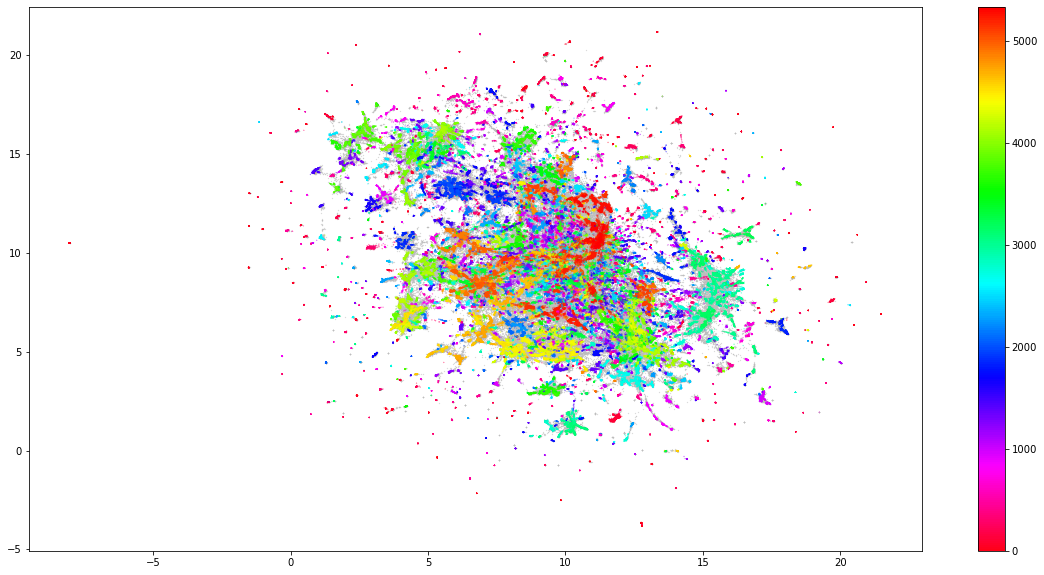

In [7]:
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

## Analisar resultados

In [9]:
# Resultados em dataframe
# Doc = query, Topic = cluster
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
display(docs_df)

,Doc,Topic,Doc_ID
0,)what was the immediate impact of the success of the manhattan pro...,3405,0
1,"_________ justice is designed to repair the harm to victim, the co...",-1,1
2,why did stalin want control of eastern europe,-1,2
3,why do nails get rusty,1721,3
4,depona ab,-1,4
...,...,...,...
809209,nasa credit union routing number,2234,809209
809210,what county is hitchcock texas located in,836,809210
809211,what is blowout for hair,1752,809211
809212,what car does isaac bell drive in the wrecker,-1,809212


In [11]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

C:\Users\Gabriel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Wall time: 2min 36s


In [12]:
%%time
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

Wall time: 33.4 s


,Topic,Size
0,-1,379229
4124,4123,2455
125,124,2277
19,18,1944
145,144,1923
297,296,1903
5330,5329,1549
5281,5280,1420
240,239,1299
975,974,1253


In [28]:
top_n_words[5]

[('titanic', 2.3870489341926615),
 ('did', 0.3555163220865293),
 ('sink', 0.2048851836055684),
 ('sank', 0.15819499117628447),
 ('ship', 0.13573630504768489),
 ('iceberg', 0.11365190544783504),
 ('people', 0.0989324842412519),
 ('jack', 0.09793926131740943),
 ('movie', 0.0740372717593079),
 ('sail', 0.06342739633979341)]

In [18]:
# palavras para procurar dentre os clusters
to_find = ['marine', 'ocean', 'sea', 'oil', 'beach', 'current', 'tide', 'wave']

In [20]:
%%time
found = {word : [] for word in to_find}
for i in range(len(top_n_words) - 1):
    for word in to_find:
        if word in [a for a,b in top_n_words[i]]:
            found[word].append(i)
            
display(found)  # clusters que possuem as palavras procuradas

{'marine': [],
 'ocean': [],
 'sea': [],
 'oil': [],
 'beach': [],
 'current': [],
 'tide': [],
 'wave': []}

{'marine': [872, 890, 896, 1559, 2356],
 'ocean': [872, 894, 905, 996, 1232, 1288, 1536, 1804, 1885, 3214, 3939],
 'sea': [222, 435, 872, 891, 894, 905, 1616, 1651, 1652, 1804, 1885, 3779],
 'oil': [452,
  1188,
  1401,
  1410,
  1412,
  1413,
  1414,
  1416,
  1417,
  1420,
  1421,
  1723,
  1834,
  1913,
  2103,
  2134,
  2473,
  2733,
  2736,
  2738,
  2817,
  2825,
  2907,
  2908],
 'beach': [1009,
  1338,
  3776,
  3827,
  3834,
  3837,
  3875,
  3939,
  3940,
  3951,
  3989,
  4001],
 'current': [43,
  563,
  571,
  628,
  660,
  700,
  731,
  1023,
  1170,
  1231,
  1536,
  1712,
  2396,
  2576,
  2578,
  3519,
  3651,
  3776,
  3805,
  3806,
  3820,
  3848,
  3849,
  3856,
  3888,
  3895,
  3953,
  4378,
  4459,
  4466,
  4775],
 'tide': [885, 3624],
 'wave': [768, 906, 1436, 2301, 2364, 3306, 3375, 3908]}

Wall time: 176 ms


In [26]:
to_find = ['marine', 'ocean', 'sea', 'oil', 'beach', 'current', 'tide', 'wave']
for i in found['wave']:
    display(i, top_n_words[i])

768

[('earthquake', 1.040887594990992),
 ('earthquakes', 0.6496351684578032),
 ('seismic', 0.4567843695269523),
 ('waves', 0.2750072986051727),
 ('scale', 0.13690641339829743),
 ('richter', 0.1334177699535238),
 ('wave', 0.09600766937608067),
 ('earth', 0.08970734085612025),
 ('magnitude', 0.08304354755766982),
 ('occur', 0.08038215549946104)]

906

[('surf', 1.503163049998379),
 ('surfboard', 1.0932608207186105),
 ('surfboards', 0.6297888538831309),
 ('wave', 0.37606906589752576),
 ('anamy', 0.3318004557357105),
 ('surfest', 0.3318004557357105),
 ('urchant', 0.3318004557357105),
 ('spheal', 0.31489442694156544),
 ('surfing', 0.2711929764725885),
 ('stringer', 0.2657504508307785)]

1436

[('transverse', 1.7231654584950564),
 ('longitudinal', 1.622102945709373),
 ('wave', 0.7089118023815428),
 ('waves', 0.7002167603010818),
 ('colon', 0.22561051857294526),
 ('difference', 0.1689648263956511),
 ('compressional', 0.13577079558547211),
 ('direction', 0.13531166330305544),
 ('definition', 0.11347726907828329),
 ('axis', 0.09587504018688785)]

2301

[('physics', 2.429305661333099),
 ('definition', 0.34447554065412056),
 ('wave', 0.10302114722805271),
 ('physicist', 0.07236901979682192),
 ('waves', 0.06783837210043889),
 ('engineering', 0.0663415563436844),
 ('period', 0.06476638983277236),
 ('does', 0.0640789899037661),
 ('force', 0.061719335977989134),
 ('horizontal', 0.060191751681711834)]

2364

[('electromagnetic', 2.0418753650330608),
 ('waves', 0.576259468950485),
 ('radiation', 0.49264900538734274),
 ('spectrum', 0.20870119859151534),
 ('wave', 0.18752633150836082),
 ('light', 0.1525806092419175),
 ('energy', 0.11288132452600701),
 ('mechanical', 0.10764140561932951),
 ('type', 0.09087804928912584),
 ('wavelengths', 0.08220067120836001)]

3306

[('sound', 1.912466813428117),
 ('waves', 0.3807428634137133),
 ('wave', 0.22674752502644935),
 ('pitch', 0.17775893440916735),
 ('definition', 0.1645420401635108),
 ('refraction', 0.14656224302114326),
 ('frequency', 0.1324543129940804),
 ('wavelength', 0.1305357480360557),
 ('intensity', 0.10834552388813753),
 ('energy', 0.087743886711392)]

3375

[('shock', 2.262678216616508),
 ('shockwave', 0.3955031792599679),
 ('absorber', 0.3924321894838634),
 ('absorbers', 0.257994384836444),
 ('effect', 0.22450661514248374),
 ('wave', 0.18139802002115948),
 ('definition', 0.15486309662448072),
 ('analeptic', 0.15189025299534334),
 ('jolt', 0.15189025299534334),
 ('dampening', 0.15189025299534334)]

3908

[('wave', 1.7419485479660561),
 ('waves', 0.6303125703045812),
 ('amplitude', 0.24109332919313625),
 ('frequency', 0.1511223705301588),
 ('speed', 0.13221726987539298),
 ('measure', 0.12014692733811118),
 ('energy', 0.1201325697256642),
 ('distance', 0.10973275956020707),
 ('crest', 0.10387394375422616),
 ('period', 0.09107864127266377)]

In [27]:
s = docs_df[docs_df['Topic'] == 3908]
display(s)
print(s.index.tolist())

,Doc,Topic,Doc_ID
8608,what is a planar waveguide,3908,8608
10907,how to find amplitude in a wave,3908,10907
19398,name of distance between nodes in a wave,3908,19398
27113,what are mechanicle waves,3908,27113
29045,polarization is a property of what kind of waves,3908,29045
...,...,...,...
795261,types of waves that can penetrate the body,3908,795261
797287,how em waves produced?,3908,797287
800295,what do waves do,3908,800295
802876,waveguide devices,3908,802876


[8608, 10907, 19398, 27113, 29045, 35839, 38160, 41681, 55599, 58944, 62442, 90447, 100207, 103429, 104553, 110271, 117350, 119618, 119682, 124340, 126678, 130906, 137884, 144631, 145883, 152668, 156402, 166891, 179921, 184779, 185592, 197536, 199005, 201476, 204924, 206753, 209781, 218628, 223379, 228044, 230212, 233048, 241777, 245579, 248595, 256229, 262628, 275807, 276650, 283103, 297064, 299610, 314402, 315662, 316427, 320629, 328696, 329453, 330155, 332824, 339141, 341267, 341370, 352559, 356052, 358118, 364775, 369927, 380858, 382224, 407968, 422313, 423839, 431151, 445664, 446872, 461097, 464174, 474461, 485374, 486162, 487673, 498197, 499240, 500233, 509781, 513455, 518930, 522699, 526485, 532679, 542587, 547229, 548763, 549111, 550669, 554411, 558363, 559270, 569709, 573767, 588715, 593258, 596054, 596544, 600798, 602552, 603149, 605029, 609226, 610183, 611892, 611981, 628959, 634570, 640432, 648771, 650244, 654661, 663419, 670281, 679484, 688987, 702812, 703594, 705641, 7147

In [12]:
# Salvar resultado
inter = [872, 905, 1885, 891, 1616, 1651, 1652, 3779, 1421, 1913, 885]  # clusters possivelmente contendo perguntas interessantes

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [27]:
inter_df = docs_df[docs_df['Topic'].apply(lambda x: x in inter)]  # linhas pertencentes aos clusters interessantes
display(inter_df)

,Doc,Topic,Doc_ID
1121,how big can miniature turtles get,1652,1121
1361,seafloor spreading definition,905,1361
1739,average production cost for oil in permian basin,1421,1739
2333,price of castor oil,1421,2333
3597,what causes waves to occur in the ocean,905,3597
...,...,...,...
804773,what could cause truck to leak oil,1421,804773
806652,is liquid fuel gas? oil?,1421,806652
806828,what is a sea compass called,905,806828
808359,Current Heating Oil Prices PA,1421,808359


In [48]:
inter_json = inter_df.drop(columns=['Topic', 'Doc_ID'])
inter_json.to_json('pre_lookup_table.json')

## Reduzir a quantidade de clusters

In [ ]:
# TOPIC REDUCTION
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

# Domain-Specific QA (IBM)
Inspirado em: https://github.com/ibm-aur-nlp/domain-specific-QA  
O código da IBM *não filtra* os tópicos, apenas pega a lista de ids já filtrados e gera  
o json contendo todas as informações relevantes a cada pergunta em cada domínio.

In [51]:
# IMPORTANTE!!
# abrir o json consome muita memória. Apague variáveis grandes antes
to_del = ['tf_idf', 'umap_embeddings', 'docs_df', 'data', 'top_n_words', 'docs_per_topic', 'topic_sizes', 's', 'inter_df', 'inter_json']
for var in to_del:
    globals().pop(var, None)

In [6]:
import json
from tqdm import tqdm


def fix_lookup(lookup):
    """
    Por algum motivo, a lookup table não anotou corretamente o query id de cada query capturada.
    Então, para cada query presente na lookup table, iteramos sobre as queries do arquivo original
    até encontrar o id correto.

    :param lookup:
    :return:
    """
    new_lookup = {}
    print('Consertando lookup! ~1min')
    for l_index, l_query in tqdm(lookup['Doc'].items()):
        real_key = next(m_index for m_index, m_query in marco_query.items() if m_query == l_query)
        new_lookup[real_key] = l_query
    return new_lookup


with open('train_v2.1_query.json', 'r') as marco_query:
    marco_query = json.load(marco_query)
    
with open('train_v2.1_answers.json', 'r') as marco_answers:
    marco_answers = json.load(marco_answers)
    
with open('train_v2.1_wellFormedAnswers.json', 'r') as marco_wfanswers:
    marco_wfanswers = json.load(marco_wfanswers)

print('Lendo lookup...')
with open('lookup_table.json', 'r') as lookupfile:
    lookup = json.load(lookupfile)

# substituir chaves pelas corretas
lookup = fix_lookup(lookup)

  4%|███▎                                                                           | 78/1844 [00:00<00:02, 772.30it/s]

Lendo lookup...
Consertando lookup! ~1min


100%|██████████████████████████████████████████████████████████████████████████████| 1844/1844 [00:46<00:00, 39.87it/s]


In [7]:
# Pega a resposta e a resposta formatada para cada pergunta
final = {}
print('Formando arquivo final...')
for qid, query in tqdm(lookup.items()):
    temp = {
        'query': query,
        'answer': marco_answers[qid][0],
        'wellFormedAnswer': marco_wfanswers[qid][0]
    }
    final[qid] = temp

100%|██████████████████████████████████████████████████████████████████████████| 1844/1844 [00:00<00:00, 368861.91it/s]

Formando arquivo final...


In [8]:
# Salva
print('Feito! Salvando...')
with open('filtered_qna2.json', 'w') as finalfile:
    json.dump(final, finalfile)

Feito! Salvando...


## Tentativa com ijson

In [2]:
# Biblioteca ijson serve para abrir grandes arquivos json
# porém não consegui fazer funcionar
import ijson
from pathlib import Path
# carregar o msmarco
path = Path().resolve().parent.__str__() + r'\edited_v2.1.json'
print(path)
f = open(path, 'rb')  # lembrar de fechar depois!!

queries_ = ijson.kvitems(f, 'marco.query.item')
queries = (v for k, v in queries_)

D:\Gabriel\Documents\TCC\MS MARCO\edited_v2.1.json


In [3]:
for query in queries:
    print(query)

In [41]:
f.close()